In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  4


In [2]:
# Tensor Flow Library
import tensorflow as tf
from tensorflow.keras import *
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import  Dense, Activation, Flatten, Dropout, BatchNormalization

## Sequential Models
from tensorflow.keras.models import Sequential 
from tensorflow.keras.models import load_model

# Common imports
import pandas as pd
import numpy as np
import re
import os
import fnmatch
from glob import glob

# to make this notebook's output stable across runs
np.random.seed(42)

#Plotting Libraries
import matplotlib.pyplot as plt

#Image Library
import matplotlib.image as mpimg
from skimage.io import imread
from PIL import Image
#OS Library
import os

In [3]:
# Where to save the figures
PROJECT_ROOT_DIR = "."

IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
from numpy import asarray
from PIL import Image
# load image
image = Image.open('./input/data/10_left.jpeg')
pixels = asarray(image)
# confirm pixel range is 0-255
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
# convert from integers to floats
pixels = pixels.astype('float32')
# normalize to the range 0-1
pixels /= 255.0
# confirm the normalization
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

Data Type: uint8
Min: 0.000, Max: 255.000
Min: 0.000, Max: 1.000


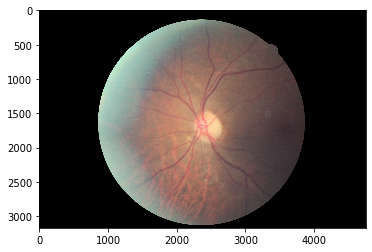

In [5]:
img = mpimg.imread('./input/data/10_left.jpeg')
plt.imshow(img)

In [6]:
img.shape

(3168, 4752, 3)

In [7]:
def myrelu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


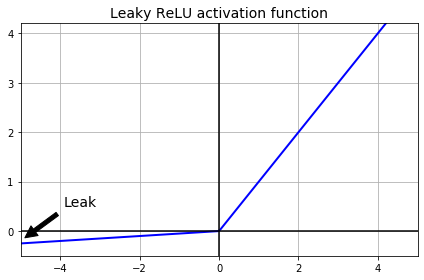

In [8]:
z = np.linspace(-5, 5, 200)

plt.plot(z, myrelu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [10]:
TrainingLabels = pd.read_csv('./input/csv/trainLabels.csv')
print(len(TrainingLabels))
TrainingLabels.level = TrainingLabels.level.map(lambda x: str(x))
TrainingLabels.image = TrainingLabels.image.map(lambda f: f + '.jpeg')
TrainingLabels.head()

35126


,image,level
0,10_left.jpeg,0
1,10_right.jpeg,0
2,13_left.jpeg,0
3,13_right.jpeg,0
4,15_left.jpeg,1


In [11]:
##Regex to grep the file name
def DataFrameToCSV(df):
    df.to_csv("TrainingData.csv",header=True,index=False)
    
def BuildTrainingData():
    getfile =re.compile(r'([\d]+_(left|right))')
    df=pd.DataFrame()

    MyDataList = glob(os.path.join("./Data/alldata",'*.jpeg'))
    DataList = []
    DataLabel= []
    DataID = []
    r = re.compile(r'[0-9]$jpeg')
    for file in MyDataList:
        #if fnmatch.fnmatch(file, '*.jpeg'):
        #print(file.split("/")[3])
        FileName=file.split("/")[3]
        tdf=pd.DataFrame({"DataID":[FileName.split("_")[0]],"DataLabel":[getfile.findall(file)[0][0]],"DataList":[FileName]})
        df=df.append(tdf)
    return df

In [12]:
from sklearn.model_selection import train_test_split
mydatadir="./input/data"
df_list = os.listdir(mydatadir)
df = pd.DataFrame(df_list, columns = ["image"])
df = pd.merge(df, TrainingLabels, on=['image'], how='inner')

train, test = train_test_split(df, test_size=0.1)
train, validation = train_test_split(train, test_size = 0.2222)

In [14]:
train['level'].value_counts(),validation['level'].value_counts(),test['level'].value_counts()

(0    18013
 2     3765
 1     1708
 3      602
 4      500
 Name: level, dtype: int64,
 0    5213
 2    1016
 1     475
 3     177
 4     144
 Name: level, dtype: int64,
 0    2584
 2     511
 1     260
 3      94
 4      64
 Name: level, dtype: int64)

In [21]:
datagen = ImageDataGenerator(
                            featurewise_center=False,
                            samplewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False,
                            zca_whitening=False,
                            rotation_range=45,
                            rescale=1./255,
                            width_shift_range=0.5,
                            height_shift_range=0.5,
                            shear_range=0.5,
                            zoom_range=0.5,
                            horizontal_flip=False,
                            validation_split = 0.222)

test_datagen = ImageDataGenerator(
                            featurewise_center=False,
                            samplewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False,
                            zca_whitening=False,
                            rotation_range=45,
                            rescale=1./255,
                            width_shift_range=0.5,
                            height_shift_range=0.5,
                            shear_range=0.5,
                            zoom_range=0.5,
                            horizontal_flip=False)

# Data Augumentation

trainingData= datagen.flow_from_dataframe(dataframe = train,
                                              directory = mydatadir,
                                              x_col = "image",
                                              y_col = "level",
                                              subset = 'training',
                                              batch_size = 512,
                                              seed = None,
                                              shuffle = True,
                                              color_mode='rgb',
                                              class_mode = 'sparse',
                                              #drop_duplicates = True,
                                              save_prefix = '',
                                              target_size = (28, 28))

validationData = datagen.flow_from_dataframe(dataframe = train,
                                                    directory = mydatadir,
                                                    x_col = "image",
                                                    y_col = "level",
                                                    subset = 'validation',
                                                    batch_size = 32,
                                                    seed = None,
                                                    shuffle = True,
                                                    color_mode='rgb',
                                                    class_mode = 'sparse',
                                                    #drop_duplicates = True,
                                                    save_prefix = '',
                                                    target_size = (28, 28))

testData = test_datagen.flow_from_dataframe(dataframe = test,
                                                    directory = mydatadir,
                                                    x_col = "image",
                                                    y_col = "level",
                                                    subset = None,
                                                    batch_size = 32,
                                                    seed = None,
                                                    shuffle = True,
                                                    color_mode='rgb',
                                                    class_mode = 'sparse',
                                                    #drop_duplicates = True,
                                                    save_prefix = '',
                                                    target_size = (28, 28))

Found 19130 validated image filenames belonging to 5 classes.
Found 5458 validated image filenames belonging to 5 classes.
Found 3513 validated image filenames belonging to 5 classes.


In [22]:
from tensorflow.keras.layers import LeakyReLU,PReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model

In [23]:
# example of creating a CNN with an efficient inception module
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Flatten, Dense
 
# function for creating a projected inception module
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation=LeakyReLU(alpha=0.1))(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2_in, (1,1), padding='same', activation=LeakyReLU(alpha=0.1))(layer_in)
    conv3 = Conv2D(f2_out, (3,3), padding='same', activation=LeakyReLU(alpha=0.1))(conv3)
    # 5x5 conv
    conv5 = Conv2D(f3_in, (1,1), padding='same', activation=LeakyReLU(alpha=0.1))(layer_in)
    conv5 = Conv2D(f3_out, (5,5), padding='same', activation=LeakyReLU(alpha=0.1))(conv5)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    pool = Conv2D(f4_out, (1,1), padding='same', activation=LeakyReLU(alpha=0.1))(pool)
    # concatenate filters, assumes filters/channels last
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 24, 24, 32)        18432     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0

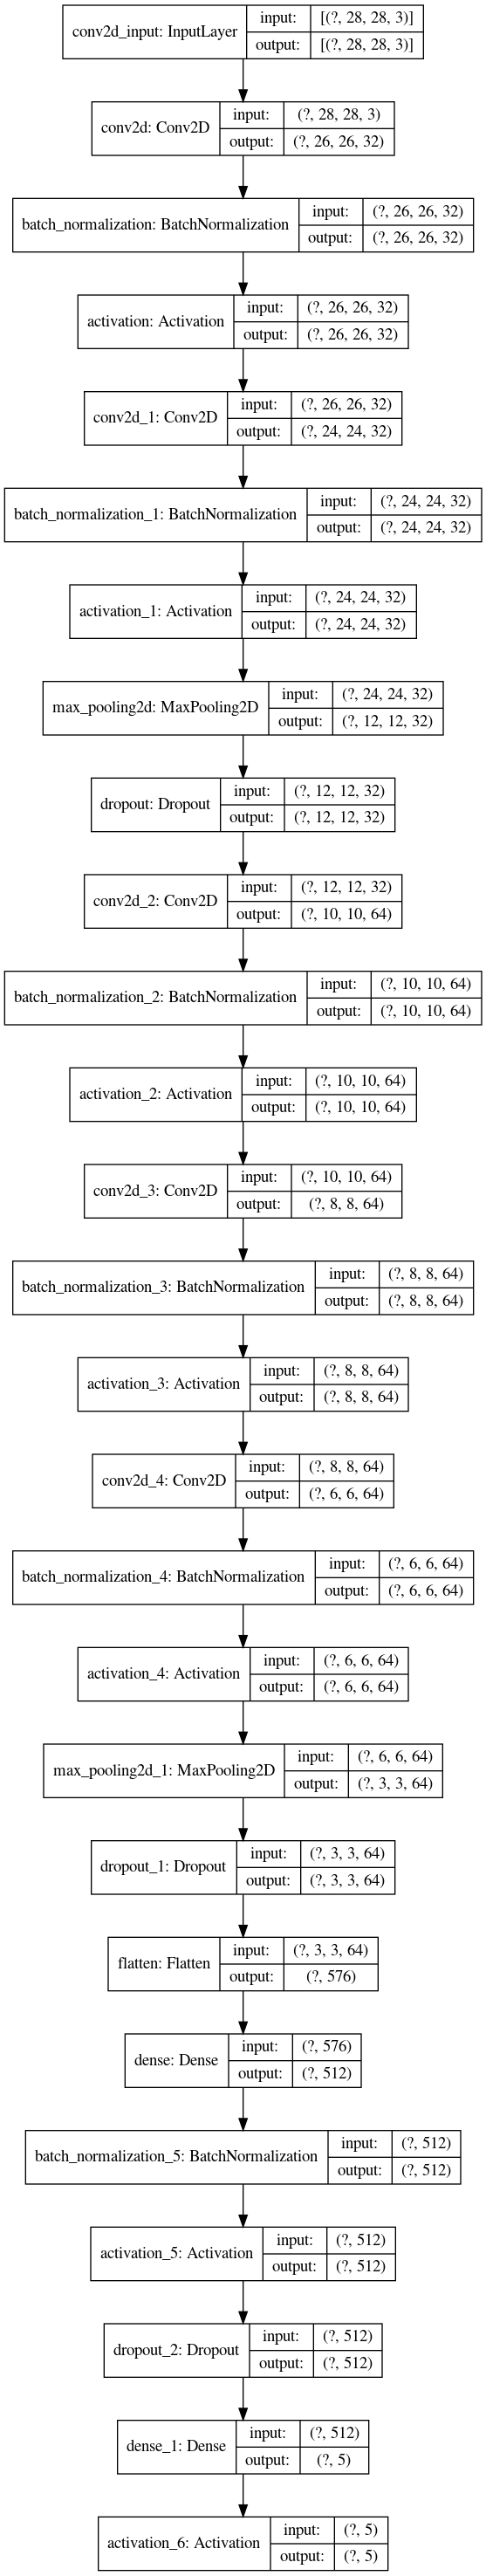

In [24]:
#Building a sequential Model
model = Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=[28, 28, 3]))
model.add(BatchNormalization(axis=-1))

#Adding a Convulution Layer with PReLU to be more balanced
#To capture small variation in data, larger filter capture larger variation in data
convLayer01 = Activation("relu")                    
model.add(convLayer01)

## Adding Batch Normalization 

model.add(layers.Conv2D(32, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation(PReLU(alpha_initializer='zeros')))

# Used MaxPooling, It does reduces the model complexity without significantky reducing the model accuracy

convLayer02 = layers.MaxPooling2D(pool_size=(2,2)) 
model.add(convLayer02)
model.add(Dropout(0.25))

model.add(layers.Conv2D(64,(3, 3)))#64 feature maps
model.add(BatchNormalization(axis=-1))               
convLayer03 = Activation(PReLU(alpha_initializer='zeros'))                    
model.add(convLayer03)

model.add(layers.Conv2D(64,(3, 3)))# 64 feature maps
model.add(BatchNormalization(axis=-1))              
convLayer04 = Activation(PReLU(alpha_initializer='zeros')) 
model.add(convLayer04)

model.add(layers.Conv2D(64, (3, 3)))# 64 feature maps
model.add(BatchNormalization(axis=-1))    
model.add(Activation(PReLU(alpha_initializer='zeros')))  
convLayer05 = layers.MaxPooling2D(pool_size=(2,2)) 
model.add(convLayer05) 
model.add(Dropout(0.25))#Dropout
model.add(layers.Flatten()) #Flatten

model.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.003))) # We can l1 

model.add(BatchNormalization())
model.add(Activation(PReLU(alpha_initializer='zeros')))  
model.add(Dropout(0.5)) 
model.add(layers.Dense(5))
model.add(Activation('softmax')) 
model.summary()

plot_model(model, show_shapes=True, to_file='CNN_Module.png')

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 28, 28, 96)   384         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 28, 28, 64)   256         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 28, 28, 3)    0           input_1[0][0]                    
_______________________________________________________________________________________

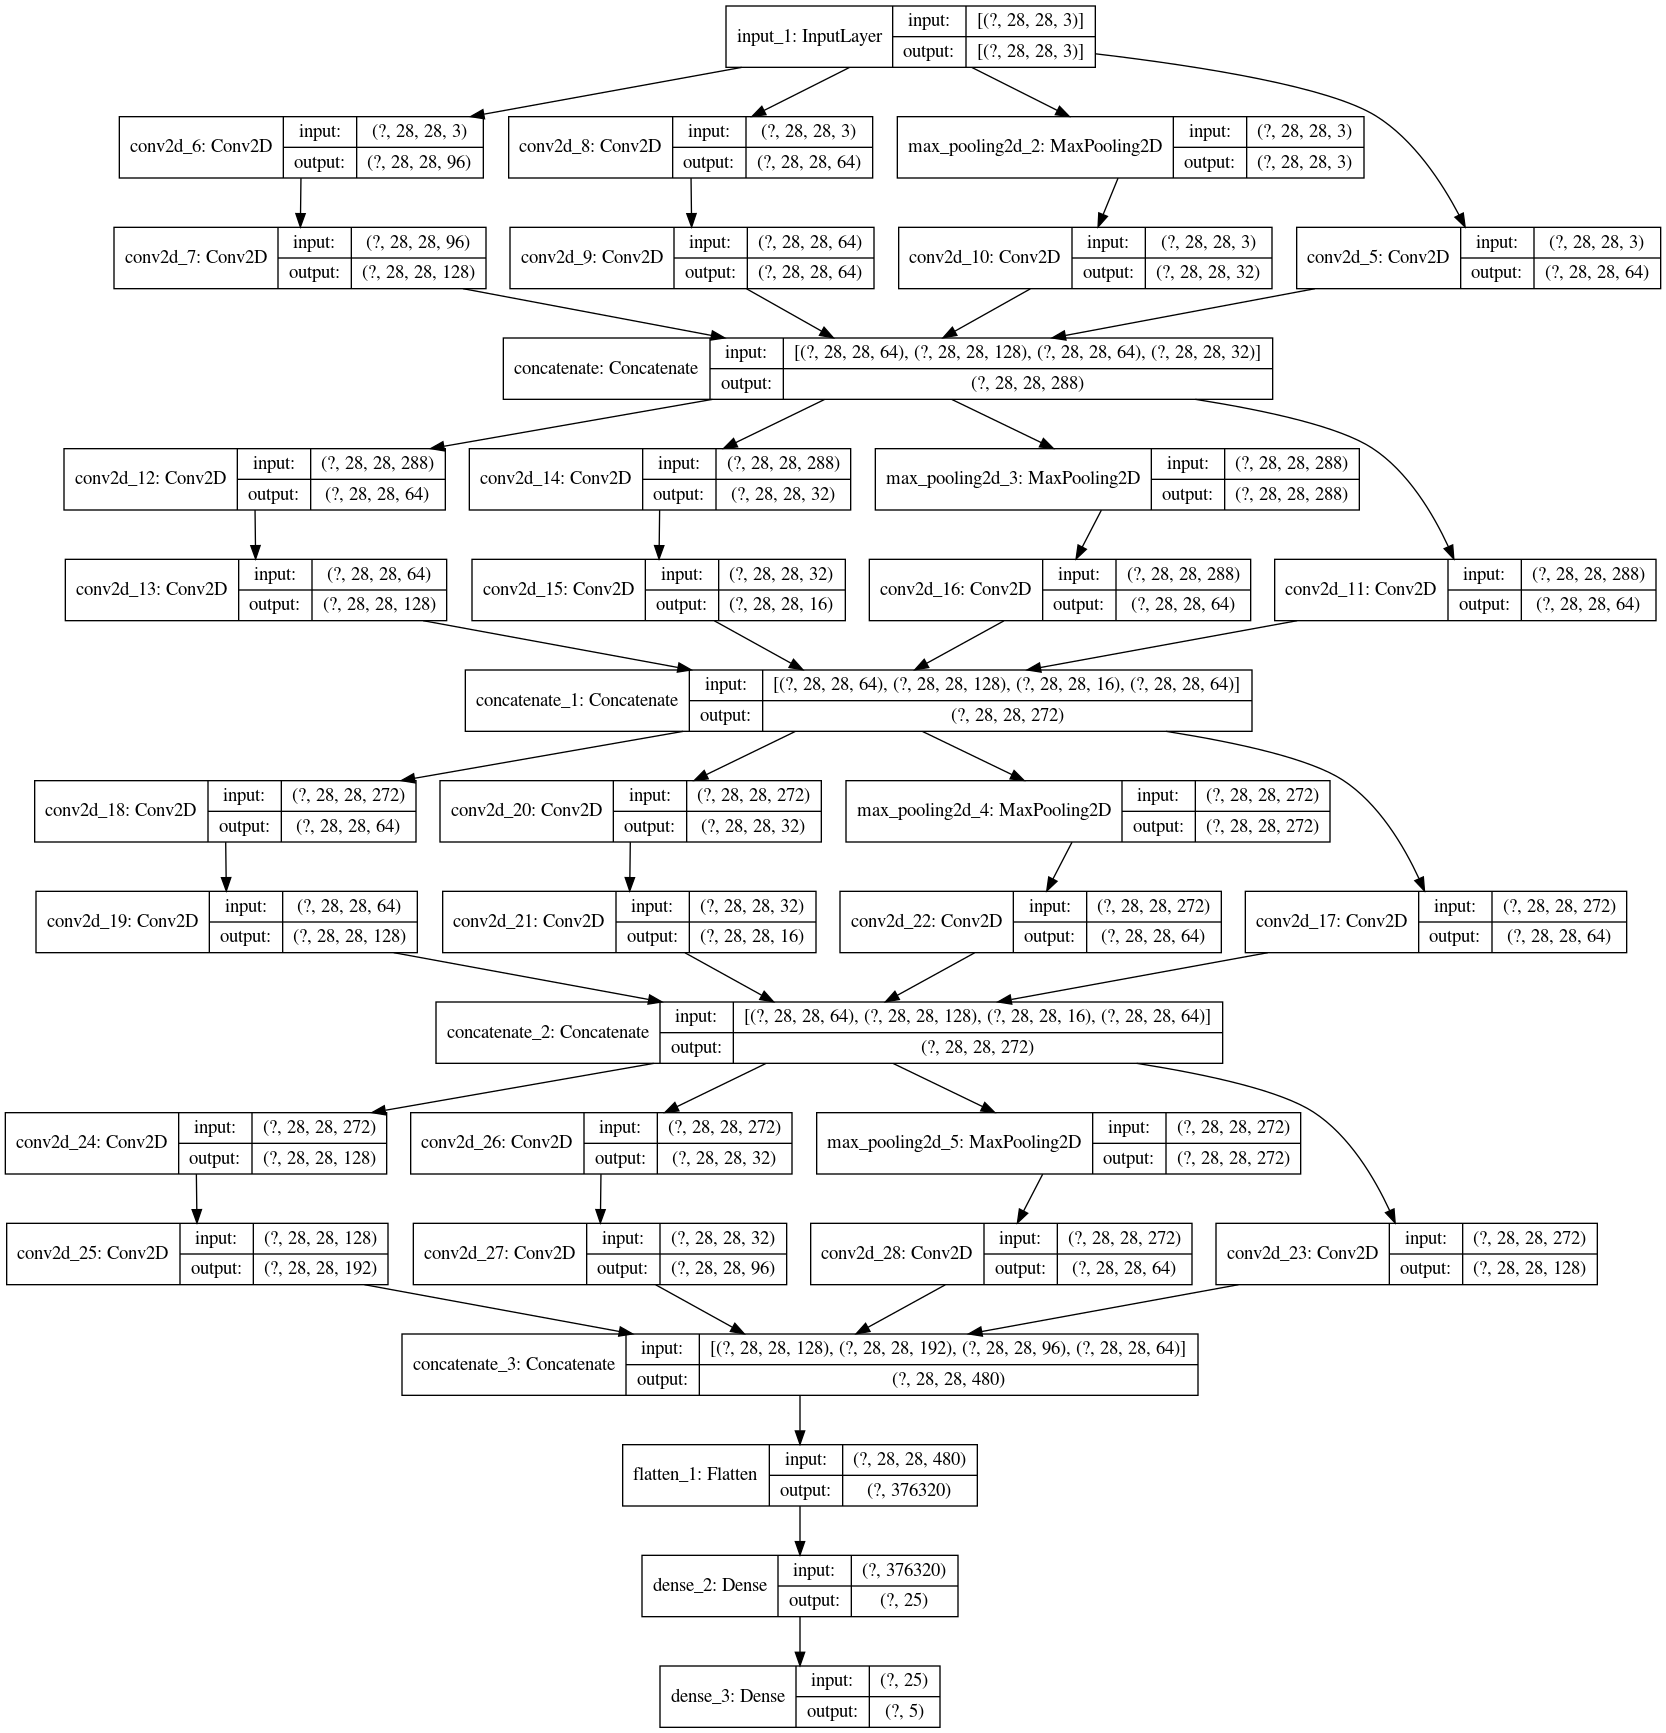

In [25]:
# define model input
visible = Input(shape=(28, 28, 3))
# add inception block 1
layer = inception_module(visible, 64, 96, 128, 64, 64, 32)

# add inception block 2
layer = inception_module(layer, 64, 64, 128, 32, 16, 64)

# add inception block 3
layer = inception_module(layer, 64, 64, 128, 32, 16, 64)

# add inception block 4
layer = inception_module(layer, 128, 128, 192, 32, 96, 64)

flatten_layer = Flatten()(layer)
dense1    = Dense(25, activation=LeakyReLU(alpha=0.1))(flatten_layer)
out    = Dense(5, activation='softmax')(dense1)
# create model
model = Model(inputs=visible, outputs=out)
# summarize model
model.summary()
#Plotting model architecture
plot_model(model, show_shapes=True, to_file='inception_module.png')

In [26]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              metrics =['accuracy'])

In [27]:
history = model.fit(
    trainingData,
    callbacks=[keras.callbacks.TensorBoard(log_dir='.input/logs/')],
    validation_data=validationData,
      epochs=15)
model.save('model_15.h5')

Epoch 1/15
 1/38 [..............................] - ETA: 0s - loss: 1.6073 - accuracy: 0.1621WARNING:tensorflow:From /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu_cuda11.0/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
38/38 [==============================] - 2239s 59s/step - loss: 0.9527 - accuracy: 0.7175 - val_loss: 0.8676 - val_accuracy: 0.7351
Epoch 2/15
38/38 [==============================] - 2285s 60s/step - loss: 0.8784 - accuracy: 0.7319 - val_loss: 0.8615 - val_accuracy: 0.7351
Epoch 3/15
38/38 [==============================] - 2309s 61s/step - loss: 0.8800 - accuracy: 0.7319 - val_loss: 0.8673 - val_accuracy: 0.7351
Epoch 4/15
38/38 [==============================] - 2319s 61s/step - loss: 0.8733 - accuracy: 0.7319 - val_loss: 0.8564 - val_accuracy: 0.7351
Epoch 5/15
38/3

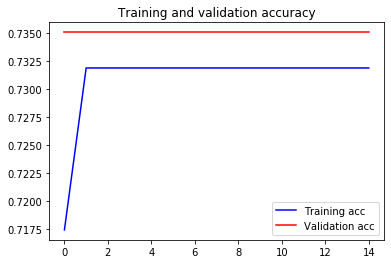

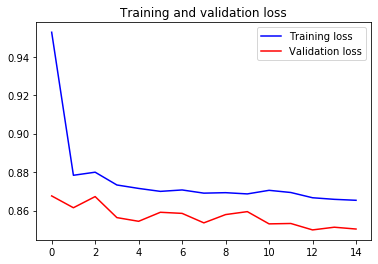

<Figure size 432x288 with 0 Axes>

In [28]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'b', label='Training acc')
plt.plot(epochs, val_accuracy, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure
plt.show()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()


plt.show()

In [29]:
model.evaluate_generator(generator=testData)

Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.8616462349891663, 0.7355536818504333]

In [30]:
predicted_classes = model.predict_generator(generator = testData)
print(predicted_classes)

Instructions for updating:
Please use Model.predict, which supports generators.
[[0.8181416  0.04140412 0.11266364 0.01142621 0.01636435]
 [0.7072067  0.06433747 0.17322095 0.02902407 0.02621081]
 [0.7066207  0.07173152 0.1613082  0.03245597 0.02788354]
 ...
 [0.7016213  0.06926585 0.17406179 0.03144381 0.02360726]
 [0.6694828  0.07570737 0.18234356 0.03576513 0.03670108]
 [0.7167031  0.06555594 0.15295975 0.03453775 0.03024351]]
